# Class Imbalance Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os

In [2]:
# set up paths
DATA_DIR = Path('../data/raw')
TRAIN_CSV = DATA_DIR / 'train.csv'
TAXONOMY_CSV = DATA_DIR  / 'taxonomy.csv'

In [3]:
# load data
train_df = pd.read_csv(TRAIN_CSV)
taxonomy_df = pd.read_csv(TAXONOMY_CSV)

In [4]:
# count recordings per species
species_counts = train_df['primary_label'].value_counts().reset_index()
species_counts.columns = ['primary_label', 'recording_count']

In [5]:
# join with taxonomy to get class information
species_counts = pd.merge(
    species_counts,
    taxonomy_df[['primary_label', 'scientific_name', 'common_name', 'class_name']],
    on = 'primary_label',
    how = 'left'
)

In [6]:
# sort by count within each class
species_counts = species_counts.sort_values(['class_name', 'recording_count'], ascending=[True, False])

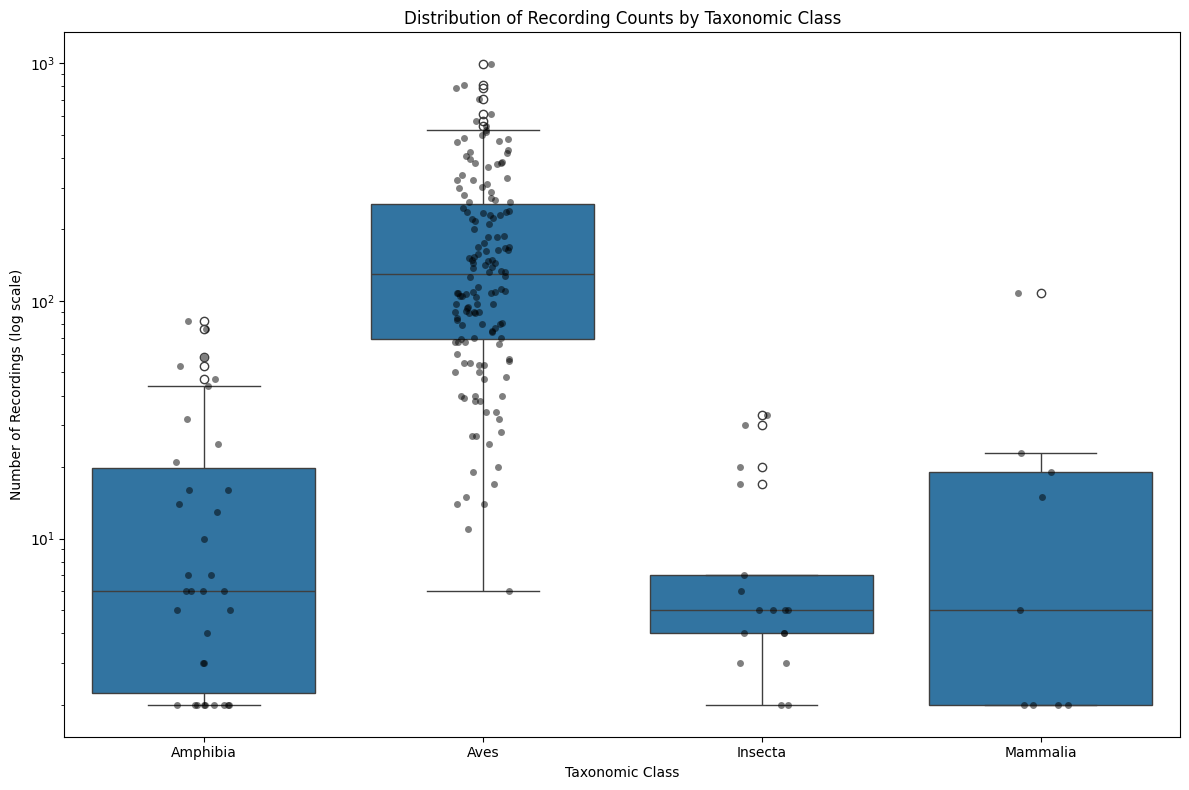

In [7]:
# visualize distribution by taxonomic class
plt.figure(figsize=(12, 8))
sns.boxplot(x='class_name', y='recording_count', data=species_counts)
sns.stripplot(x='class_name', y='recording_count', data=species_counts,
              color='black', alpha=0.5, jitter=True)
plt.yscale('log')   # log scale helps visualize wide range of counts
plt.title('Distribution of Recording Counts by Taxonomic Class')
plt.xlabel('Taxonomic Class')
plt.ylabel('Number of Recordings (log scale)')
plt.tight_layout()
plt.show()

In [9]:
# identify underrepresented species (e.g., fewer than 10 recordings)
underrepresented = species_counts[species_counts['recording_count'] < 10]
print(f"Found {len(underrepresented)} underrepresented species (fewer than 10 recordings):")
print(underrepresented[['primary_label', 'common_name', 'recording_count', 'class_name']])

Found 39 underrepresented species (fewer than 10 recordings):
    primary_label                      common_name  recording_count class_name
167         65547              Tatayo's Glass Frog                7   Amphibia
168        787625           Santa Rita Rocket Frog                7   Amphibia
171        555142        Chirique-Flusse Tree Frog                6   Amphibia
172        126247           Spotted Foam-nest Frog                6   Amphibia
173         65336       Bogert's Aquatic Tree Frog                6   Amphibia
175         24272                 Masked Tree Frog                6   Amphibia
180        476538              Panama Humming Frog                5   Amphibia
182         66893                 Banded Rain Frog                5   Amphibia
183        134933               Emerald Glass Frog                4   Amphibia
187         24292        Caracas Snouted Tree Frog                3   Amphibia
188         65419           Esmereldas Robber Frog                3  

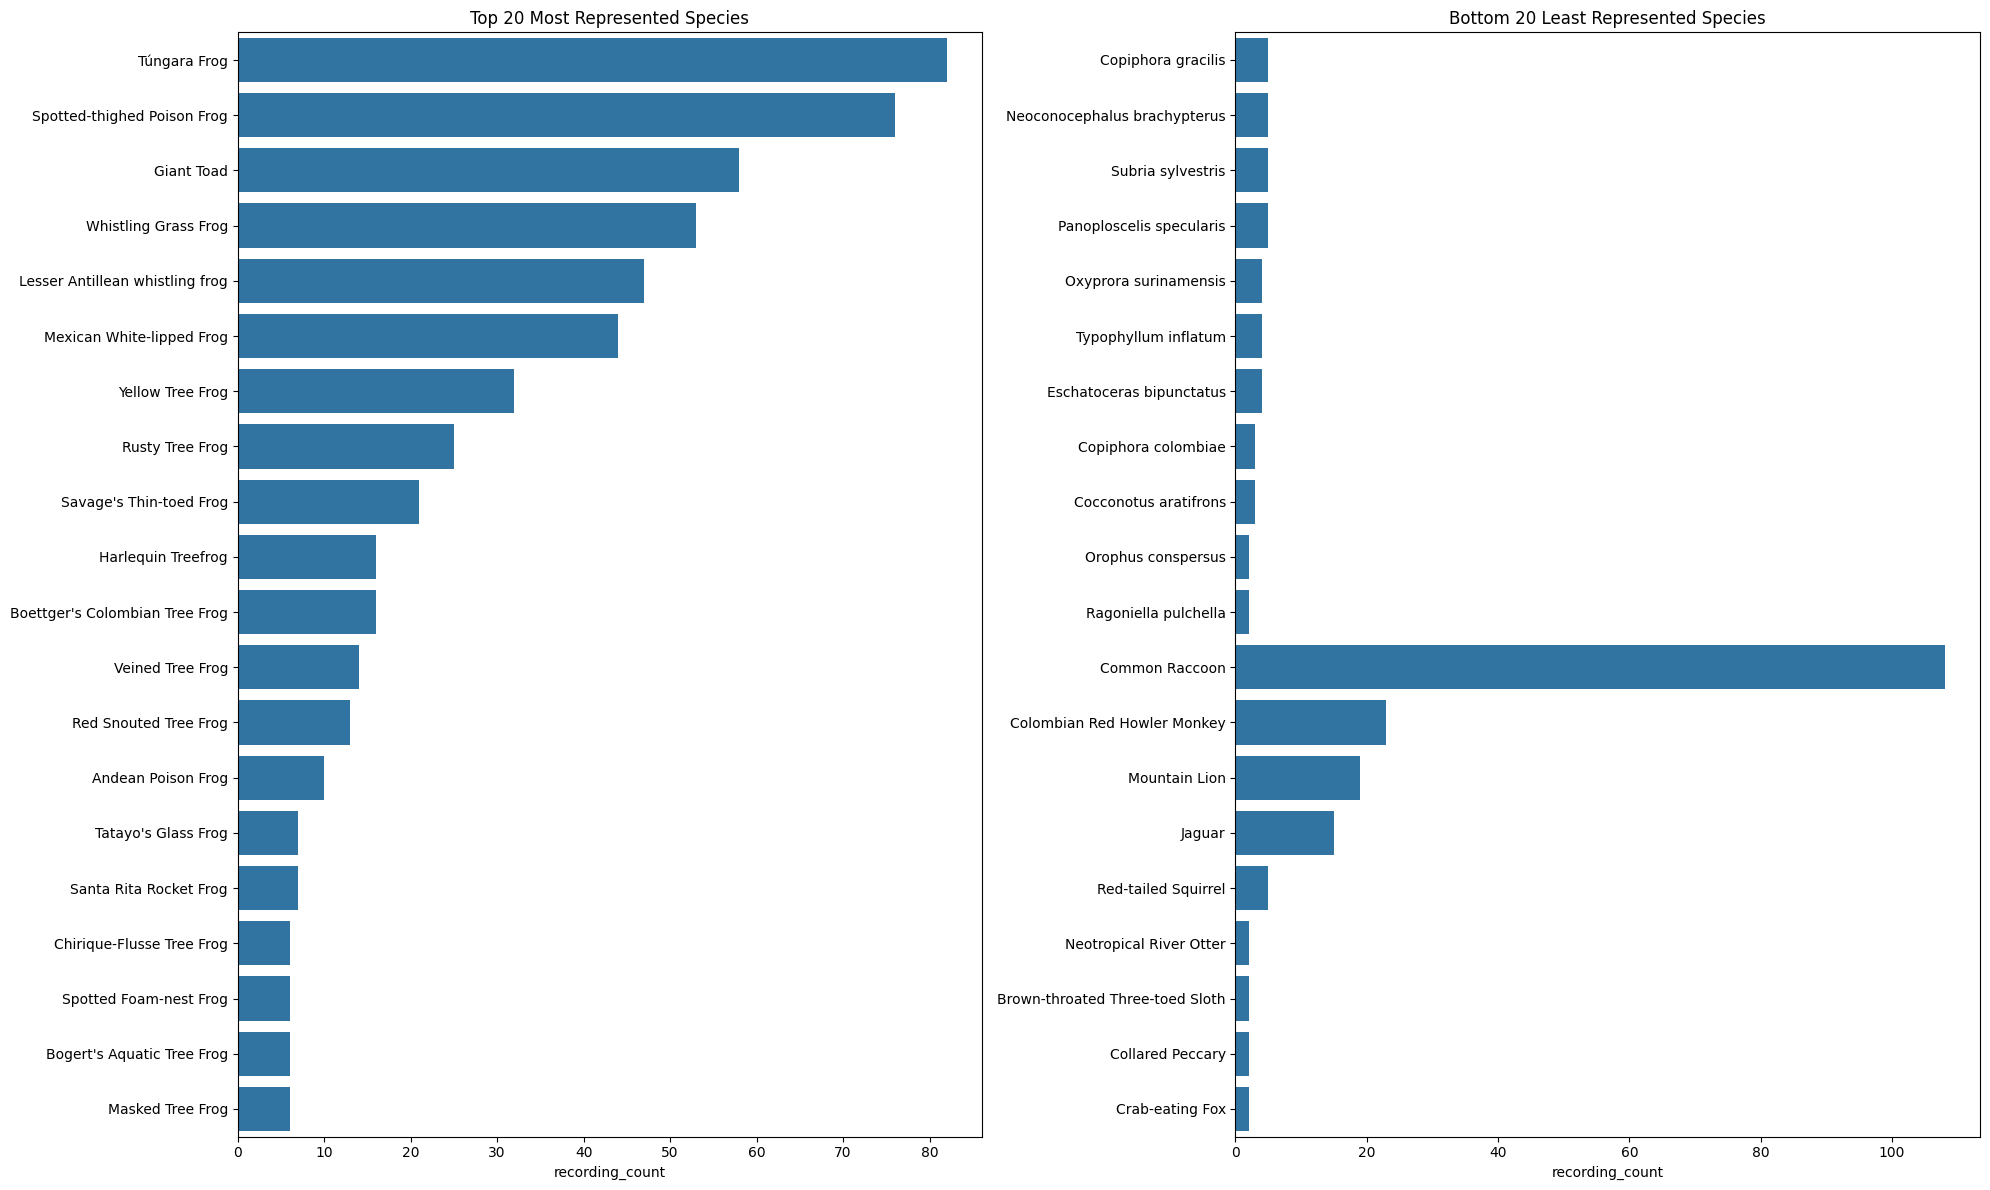

In [12]:
# create horizontal bar chart of species counts (top 20 and bottom 20)
fig, axes = plt.subplots(1, 2, figsize=(20, 12))

# top 20 most represented species
top20 = species_counts.head(20)
sns.barplot(y='common_name', x='recording_count', data=top20, ax=axes[0])
axes[0].set_title('Top 20 Most Represented Species')
axes[0].set_ylabel('')

bottom20 = species_counts.tail(20)
sns.barplot(y='common_name', x='recording_count', data=bottom20, ax=axes[1])
axes[1].set_title('Bottom 20 Least Represented Species')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

In [13]:
# calculate statistics
class_stats = species_counts.groupby('class_name').agg(
    total_recordings = ('recording_count', 'sum'),
    total_species = ('primary_label', 'count'),
    min_recordings = ('recording_count', 'min'),
    max_recordings = ('recording_count', 'max'),
    median_recordings = ('recording_count', 'median'),
    mean_recordings = ('recording_count', 'mean')
).reset_index()

print("Statistics by taxonomic class:")
print(class_stats)

Statistics by taxonomic class:
  class_name  total_recordings  total_species  min_recordings  max_recordings  \
0   Amphibia               583             34               2              82   
1       Aves             27648            146               6             990   
2    Insecta               155             17               2              33   
3   Mammalia               178              9               2             108   

   median_recordings  mean_recordings  
0                6.0        17.147059  
1              129.5       189.369863  
2                5.0         9.117647  
3                5.0        19.777778  


In [14]:
# save the analysis results for future reference
os.makedirs('../data/interim', exist_ok=True)
species_counts.to_csv('../data/interim/species_counts.csv', index=False)